<a href="https://colab.research.google.com/github/Kevin-J-Mathew/Python-Projects/blob/main/Research_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras import layers, models
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.utils import class_weight
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from sklearn.utils import class_weight
import numpy as np


**PREPROCESSING**

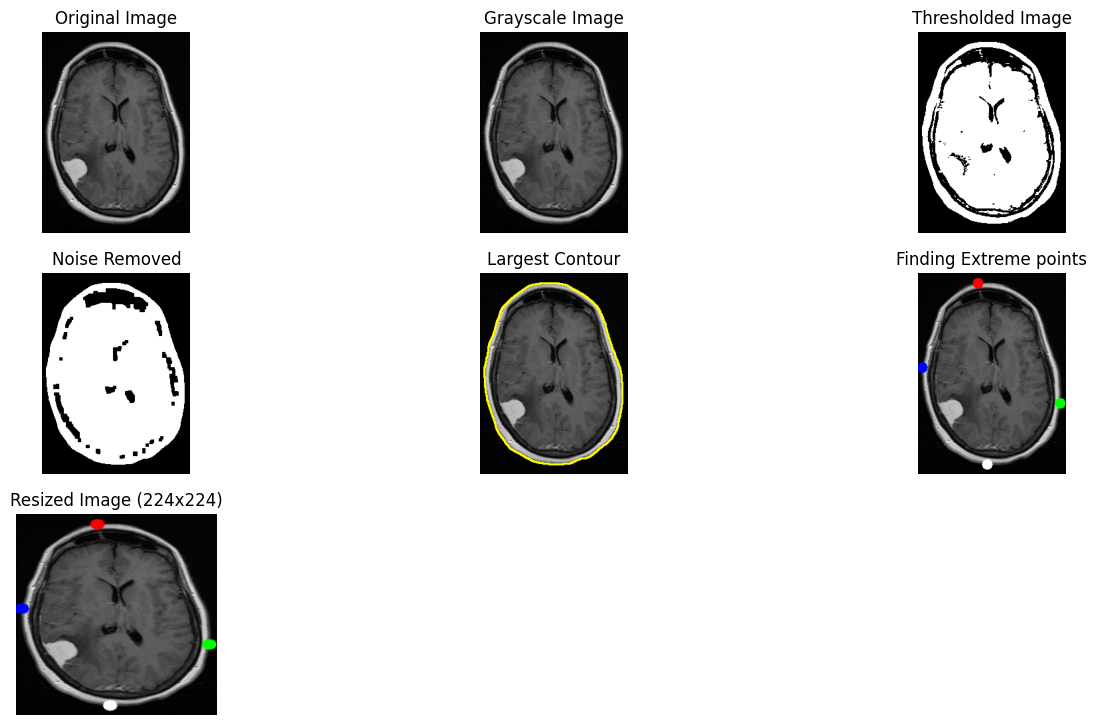

In [ ]:
import cv2
import numpy as np
import os
from pathlib import Path
from matplotlib import pyplot as plt

def preprocess_image(image_path, display=False):
    # Loading the image
    image = cv2.imread(image_path)

    # Step 1: Original Image
    if display:
        plt.figure(figsize=(16, 12))  # Adjust figure size to accommodate more subplots
        plt.subplot(4, 3, 1)  # Change to 3 rows, 3 columns
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')

    # Step 2: Converting to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if display:
        plt.subplot(4, 3, 2)
        plt.imshow(gray, cmap='gray')
        plt.title('Grayscale Image')
        plt.axis('off')

    # Step 3: Apply threshold to convert grayscale image to binary
    _, thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)
    if display:
        plt.subplot(4, 3, 3)
        plt.imshow(thresh, cmap='gray')
        plt.title('Thresholded Image')
        plt.axis('off')

    # Step 4: Removing noise using dilation and erosion
    kernel = np.ones((5, 5), np.uint8)
    thresh_cleaned = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    thresh_cleaned = cv2.morphologyEx(thresh_cleaned, cv2.MORPH_OPEN, kernel)
    if display:
        plt.subplot(4, 3, 4)
        plt.imshow(thresh_cleaned, cmap='gray')
        plt.title('Noise Removed')
        plt.axis('off')

    # Step 5: Finding contours and grabbing the largest one
    contours, _ = cv2.findContours(thresh_cleaned.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None
    largest_contour = max(contours, key=cv2.contourArea)

    # **Draw the largest contour**
    image_contour = image.copy()
    cv2.drawContours(image_contour, [largest_contour], -1, (0, 255, 255), 2)  # Contour in yellow
    if display:
        plt.subplot(4, 3, 5)
        plt.imshow(cv2.cvtColor(image_contour, cv2.COLOR_BGR2RGB))
        plt.title('Largest Contour')
        plt.axis('off')

    # Step 6: Finding extreme points and cropping the image
    extLeft = tuple(largest_contour[largest_contour[:, :, 0].argmin()][0])
    extRight = tuple(largest_contour[largest_contour[:, :, 0].argmax()][0])
    extTop = tuple(largest_contour[largest_contour[:, :, 1].argmin()][0])
    extBot = tuple(largest_contour[largest_contour[:, :, 1].argmax()][0])

    # **Mark Extreme Points on the Image**
    image_extreme = image.copy()
    cv2.circle(image_extreme, extLeft, 8, (255, 0, 0), -1)   # Left in blue
    cv2.circle(image_extreme, extRight, 8, (0, 255, 0), -1)  # Right in green
    cv2.circle(image_extreme, extTop, 8, (0, 0, 255), -1)    # Top in red
    cv2.circle(image_extreme, extBot, 8, (255, 255, 255), -1)  # Bottom in white
    if display:
        plt.subplot(4, 3, 6)
        plt.imshow(cv2.cvtColor(image_extreme, cv2.COLOR_BGR2RGB))
        plt.title('Finding Extreme points')
        plt.axis('off')


    # Step 8: Resize the image to (224, 224)
    resized_image = cv2.resize(image_extreme, (224, 224))
    if display:
        plt.subplot(4, 3, 7)
        plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
        plt.title('Resized Image (224x224)')
        plt.axis('off')

        # Show the full process
        plt.show()

    return resized_image

def preprocess_and_save_images(input_dir, output_dir):
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    displayed_image = False  # To track whether we've already displayed an image

    for class_dir in input_dir.iterdir():
        if class_dir.is_dir():
            class_name = class_dir.name
            output_class_dir = output_dir / ('PRE-' + class_name)
            output_class_dir.mkdir(parents=True, exist_ok=True)

            for file_path in class_dir.glob('*'):
                if file_path.suffix.lower() in ['.png', '.jpg', '.jpeg']:
                    # Display only for the first image
                    display = not displayed_image
                    processed_image = preprocess_image(str(file_path), display=display)
                    if processed_image is not None:
                        output_path = output_class_dir / file_path.name
                        cv2.imwrite(str(output_path), processed_image)

                    # Mark that the first image has been displayed
                    if display:
                        displayed_image = True

# Input directories for YES and NO classes
input_dir = '/content/drive/MyDrive/BR35H New/br35h new'
output_dir = '/content/drive/MyDrive/BR35H New/Pre Final'

# Call the function to preprocess and save images
preprocess_and_save_images(input_dir, output_dir)


**SPLITTING**

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths for the original dataset and output
dataset_path = '/content/drive/MyDrive/BR35H New/Pre Final'  # Original dataset path containing 'yes' and 'no' folders
output_path = '/content/drive/MyDrive/BR35H New/After Split'  # Output folder where train/validation/test folders will be created

# Set paths for the 'yes' (tumor) and 'no' (non-tumor) folders
yes_folder = os.path.join(dataset_path, 'PRE-yes')
no_folder = os.path.join(dataset_path, 'PRE-no')

# Get a list of all images in the 'yes' and 'no' folders
yes_images = os.listdir(yes_folder)
no_images = os.listdir(no_folder)

# Step 1: Split data into 70% train and 30% (test + validation)
yes_train, yes_temp = train_test_split(yes_images, test_size=0.3, random_state=42)
no_train, no_temp = train_test_split(no_images, test_size=0.3, random_state=42)

# Step 2: Split the remaining 30% into 15% validation and 15% test
yes_val, yes_test = train_test_split(yes_temp, test_size=0.5, random_state=42)
no_val, no_test = train_test_split(no_temp, test_size=0.5, random_state=42)

# Create directories for train, validation, and test sets
def create_dir(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

for folder in ['train', 'validation', 'test']:
    create_dir(os.path.join(output_path, folder, 'yes'))
    create_dir(os.path.join(output_path, folder, 'no'))

# Function to copy files from source to destination
def copy_files(file_list, src_folder, dest_folder):
    for file_name in file_list:
        shutil.copy(os.path.join(src_folder, file_name), os.path.join(dest_folder, file_name))

# Copy 'yes' (tumor) images to their respective folders
copy_files(yes_train, yes_folder, os.path.join(output_path, 'train', 'yes'))
copy_files(yes_val, yes_folder, os.path.join(output_path, 'validation', 'yes'))
copy_files(yes_test, yes_folder, os.path.join(output_path, 'test', 'yes'))

# Copy 'no' (non-tumor) images to their respective folders
copy_files(no_train, no_folder, os.path.join(output_path, 'train', 'no'))
copy_files(no_val, no_folder, os.path.join(output_path, 'validation', 'no'))
copy_files(no_test, no_folder, os.path.join(output_path, 'test', 'no'))

print("Dataset successfully split into train (70%), validation (15%), and test (15%) sets!")


Dataset successfully split into train (70%), validation (15%), and test (15%) sets!


**LOADING THE DATA**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation and test
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data from the 'train' folder with augmentation
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/BR35H New/After Split/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['yes', 'no']  # Change to 'yes' and 'no' as per folder names
)

# Load validation data from the 'validation' folder without augmentation
validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/BR35H New/After Split/validation',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['yes', 'no']  # Change to 'yes' and 'no' as per folder names
)

# Load test data from the 'test' folder without augmentation
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/BR35H New/After Split/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['yes', 'no']  # Change to 'yes' and 'no' as per folder names
)




Found 2100 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Found 450 images belonging to 2 classes.


**MODEL TRAINING**

In [ ]:
# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation and test
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data from the 'train' folder with augmentation
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/BR35H New/After Split/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['yes', 'no']  # Assuming folder names are 'yes' and 'no'
)

# Load validation data from the 'validation' folder without augmentation
validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/BR35H New/After Split/validation',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['yes', 'no']  # Assuming folder names are 'yes' and 'no'
)

# Load test data from the 'test' folder without augmentation
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/BR35H New/After Split/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['yes', 'no']  # Assuming folder names are 'yes' and 'no'
)

# Loading EfficientNetV2M as base model
base_model = EfficientNetV2M(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Custom classification head with Dropout
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)  # Added dropout for regularization
x = Dense(128, activation='relu')(x)  # Fully connected layer
x = Dropout(0.3)(x)  # Another dropout layer
output = Dense(1, activation='sigmoid')(x)  # Binary classification output

# Defining the full model
model = Model(inputs=base_model.input, outputs=output)

# Gradually unfreeze layers
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=BinaryCrossentropy(),
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

# Calculate class weights for imbalance handling
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Callbacks
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Train the model with class weights
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    class_weight=dict(enumerate(class_weights)),
    callbacks=[lr_scheduler, early_stopping]
)

# Print model summary
model.summary()



Found 2100 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - AUC: 0.5399 - Precision: 0.5319 - Recall: 0.5513 - accuracy: 0.5312 - loss: 0.6944 - val_AUC: 0.7624 - val_Precision: 0.7913 - val_Recall: 0.4044 - val_accuracy: 0.6489 - val_loss: 0.6608 - learning_rate: 1.0000e-04
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 38s 531ms/step - AUC: 0.5919 - Precision: 0.5744 - Recall: 0.5251 - accuracy: 0.5713 - loss: 0.6804 - val_AUC: 0.7783 - val_Precision: 0.8913 - val_Recall: 0.1822 - val_accuracy: 0.5800 - val_loss: 0.6545 - learning_rate: 1.0000e-04
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 534ms/step - AUC: 0.6267 - Precision: 0.5798 - Recall: 0.5195 - accuracy: 0.5728 - loss: 0.6669 - val_AUC: 0.7869 - val_Precision: 0.8955 - val_Recall: 0.2667 - val_accuracy: 0.6178 - val_loss: 0.6301 - learning_rate: 1.0000e-04
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 526ms/step - AUC: 0.6478 - Precision: 0.5966 - Recall: 0.5917 - accuracy: 0.5976 - loss: 0.6581 - val_AUC: 0.7866 - val_Precision: 0.8846 - val_Recall: 0.2044

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 24)   │            648 │ rescaling_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 24)   │             96 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 24)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 112, 112, 24)   │          5,184 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 112, 112, 24)   │             96 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 112, 112, 24)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_add (Add)         │ (None, 112, 112, 24)   │              0 │ block1a_project_activ… │
│                           │                        │                │ stem_activation[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_conv      │ (None, 112, 112, 24)   │          5,184 │ block1a_add[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_bn        │ (None, 112, 112, 24)   │             96 │ block1b_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_activati… │ (None, 112, 112, 24)   │              0 │ block1b_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_drop (Dropout)    │ (None, 112, 112, 24)   │              0 │ block1b_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_add (Add)         │ (None, 112, 112, 24)   │              0 │ block1b_drop[0][0],    │
│                           │                        │                │ block1a_add[0][0]      │
├──────────────────────

 Total params: 78,816,441 (300.66 MB)

 Trainable params: 12,750,977 (48.64 MB)

 Non-trainable params: 40,563,508 (154.74 MB)

 Optimizer params: 25,501,956 (97.28 MB)

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
import math
from sklearn.utils import class_weight
import numpy as np

# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,  # Added vertical flip
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]  # Added brightness augmentation
)

# Only rescaling for validation and test
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/BR35H New/After Split/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['yes', 'no']
)

# Load validation data
validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/BR35H New/After Split/validation',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['yes', 'no']
)

# Load test data
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/BR35H New/After Split/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['yes', 'no']
)

# Loading EfficientNetV2M as base model
base_model = EfficientNetV2M(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Custom classification head with Dropout and L2 Regularization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)  # L2 regularization
x = Dropout(0.4)(x)  # Increased dropout
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.4)(x)  # Increased dropout
output = Dense(1, activation='sigmoid')(x)  # Binary classification output

# Defining the full model
model = Model(inputs=base_model.input, outputs=output)

# Gradually unfreeze layers: Freeze fewer layers initially
for layer in base_model.layers[:-30]:  # Unfreeze more layers for better learning
    layer.trainable = False

# Compile the model using Adam for better early-stage convergence
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

# Calculate class weights for imbalance handling
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# OneCycleLR callback for cyclical learning rate
def one_cycle_schedule(epoch, max_lr=0.01, total_epochs=40):
    """Applies OneCycle learning rate strategy."""
    lr_start = 1e-4
    if epoch < total_epochs // 2:
        lr = lr_start + (max_lr - lr_start) * (epoch / (total_epochs // 2))
    else:
        lr = max_lr - (max_lr - lr_start) * ((epoch - total_epochs // 2) / (total_epochs // 2))
    return lr

lr_scheduler = LearningRateScheduler(one_cycle_schedule)

# Other Callbacks
reduce_lr_on_plateau = ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(patience=7, restore_best_weights=True)

# Train the model with class weights
history = model.fit(
    train_generator,
    epochs=40,  # Increased epochs
    validation_data=validation_generator,
    class_weight=dict(enumerate(class_weights)),
    callbacks=[lr_scheduler, reduce_lr_on_plateau, early_stopping]
)

# Print model summary
model.summary()

# Unfreeze more layers for fine-tuning
for layer in base_model.layers[:-10]:  # Unfreeze more layers for fine-tuning
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

# Fine-tuning for additional epochs
history_finetune = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    class_weight=dict(enumerate(class_weights)),
    callbacks=[reduce_lr_on_plateau, early_stopping]
)

# Evaluate the model on test data
test_loss, test_accuracy, test_auc, test_precision, test_recall = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")


Found 2100 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - AUC: 0.5108 - Precision: 0.5174 - Recall: 0.4847 - accuracy: 0.5026 - loss: 6.3884 - val_AUC: 0.7090 - val_Precision: 0.5363 - val_Recall: 0.9200 - val_accuracy: 0.5622 - val_loss: 5.5302 - learning_rate: 1.0000e-04
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 83s 620ms/step - AUC: 0.4829 - Precision: 0.4743 - Recall: 0.3865 - accuracy: 0.4883 - loss: 5.2685 - val_AUC: 0.7223 - val_Precision: 0.5103 - val_Recall: 0.9867 - val_accuracy: 0.5200 - val_loss: 4.5100 - learning_rate: 1.0000e-04
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 81s 617ms/step - AUC: 0.5321 - Precision: 0.5165 - Recall: 0.6392 - accuracy: 0.5227 - loss: 4.2924 - val_AUC: 0.7416 - val_Precision: 0.6172 - val_Recall: 0.8311 - val_accuracy: 0.6578 - val_loss: 3.6760 - learning_rate: 1.0000e-04
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 44s 609ms/step - AUC: 0.5238 - Precision: 0.5172 - Recall: 0.6578 - accuracy: 0.5268 - loss: 3.5072 - val_AUC: 0.7438 - val_Precision: 0.8074 - val_Recall: 0.4844

**SAVING THE MODEL**

In [ ]:
# Save the model to your Google Drive for future access
model.save('/content/drive/MyDrive/EFFICIENTNETV2M_FinalVersion.keras')


**LOADING SAVED MODEL**

In [ ]:
from tensorflow.keras.models import load_model

# Load the model from Google Drive or wherever it's saved
model = load_model('/content/drive/MyDrive/EFFICIENTNETV2M_FinalVersion.keras')

# Now you can test the model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.2f}")


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 161s 10s/step - accuracy: 0.9982 - loss: 0.0047
Test Accuracy: 1.00


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step


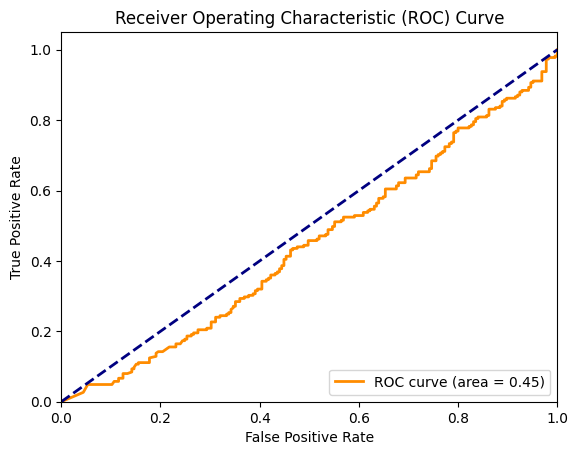

AUC: 0.45


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get the true labels and predicted probabilities from the validation generator
y_true = validation_generator.classes
y_pred_proba = model.predict(test_generator)

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print AUC score
print(f"AUC: {roc_auc:.2f}")
